# fit a baseline to the calibrated spectra and apply barycentric velocity correction
#### 1/11/22 jpw

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.coordinates import ICRS, LSR
import plot_params
%matplotlib inline

### functions

In [3]:
# function to calculate (additive) arycentric velocity correction to the data
def vbary(l, b, tobs):
    IfA_courtyard = EarthLocation(lat=21.3036944*u.deg, lon=-157.8116667*u.deg, height=372*u.m)
    home = EarthLocation(lat=21.427442*u.deg, lon=-157.794749*u.deg, height=50*u.m)
    here = home
    t = Time(tobs, scale='utc')
    c = SkyCoord(l, b, frame='galactic', unit='deg')
    barycorr = c.radial_velocity_correction(kind='barycentric', obstime=t, location=here)
    return barycorr.to(u.km/u.s).value

### code

In [4]:
# go to the data directory
path = '../example_data'
os.chdir(path)
cwd = os.getcwd()

In [6]:
# look at the raw data to get the longitude and observation time
obs = {"file":[], "longitude":[], "tobs":[]}
for f in os.listdir():
    if os.path.isdir(f) and f[0:3]=='lon' and len(f)==5:
        l = int(f[-2:])
        spectra = glob.glob(f+'/*.csv')
        tobs = spectra[0][6:25].strip().replace('_',' ').replace('.',':')
        obs["file"].append(f)
        obs["longitude"].append(l)
        obs["tobs"].append(tobs)
#print(obs)

{'file': ['lon10', 'lon20', 'lon30', 'lon40', 'lon50', 'lon60', 'lon70', 'lon80', 'lon90'], 'longitude': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'tobs': ['2022-01-08 15:04:47', '2022-01-08 15:22:24', '2022-01-08 15:37:02', '2022-01-08 15:52:53', '2022-01-08 16:20:00', '2022-01-08 16:35:03', '2022-01-08 16:59:56', '2022-01-08 17:14:44', '2022-01-08 17:27:38']}


Creating subdirectory reduced_spectra  in  /Volumes/GoogleDrive/My Drive/Classes/radio/HI_telescope/example_data
calibrated_spectra/lon10_cal.csv Barycentric correction =   8.82 km/s, LSR correction =  10.95 km/s
Writing reduced spectrum to  lon10_reduced.csv
calibrated_spectra/lon20_cal.csv Barycentric correction =   6.13 km/s, LSR correction =  12.56 km/s
Writing reduced spectrum to  lon20_reduced.csv
calibrated_spectra/lon30_cal.csv Barycentric correction =   3.26 km/s, LSR correction =  13.79 km/s
Writing reduced spectrum to  lon30_reduced.csv
calibrated_spectra/lon40_cal.csv Barycentric correction =   0.29 km/s, LSR correction =  14.61 km/s
Writing reduced spectrum to  lon40_reduced.csv
calibrated_spectra/lon50_cal.csv Barycentric correction =  -2.68 km/s, LSR correction =  14.98 km/s
Writing reduced spectrum to  lon50_reduced.csv
calibrated_spectra/lon60_cal.csv Barycentric correction =  -5.58 km/s, LSR correction =  14.89 km/s
Writing reduced spectrum to  lon60_reduced.csv
calib

<Figure size 864x576 with 0 Axes>

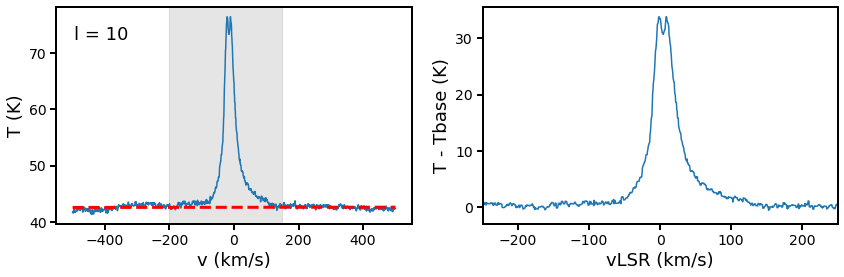

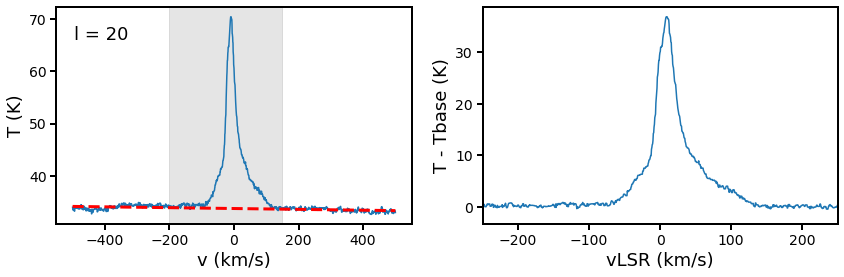

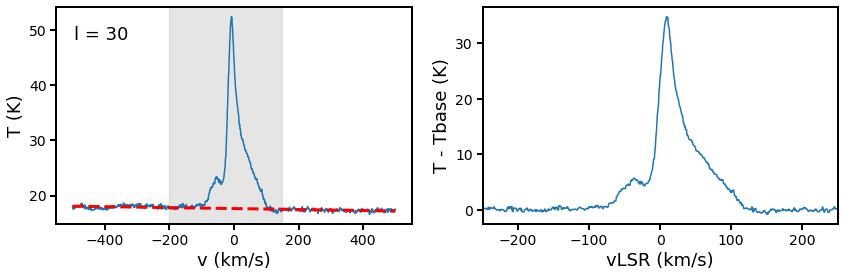

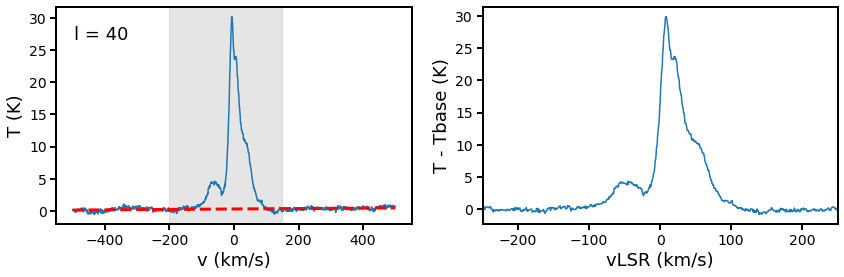

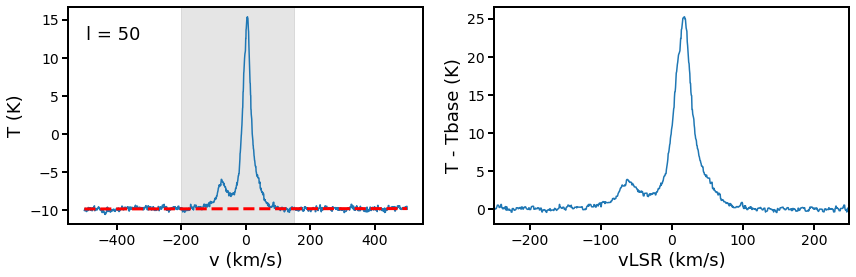

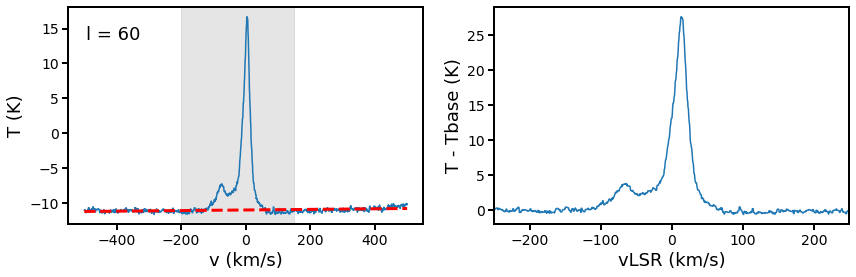

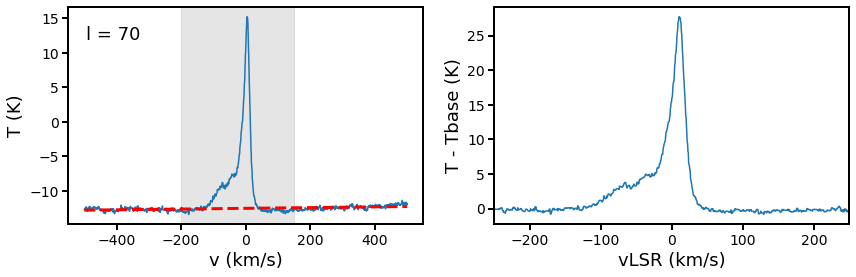

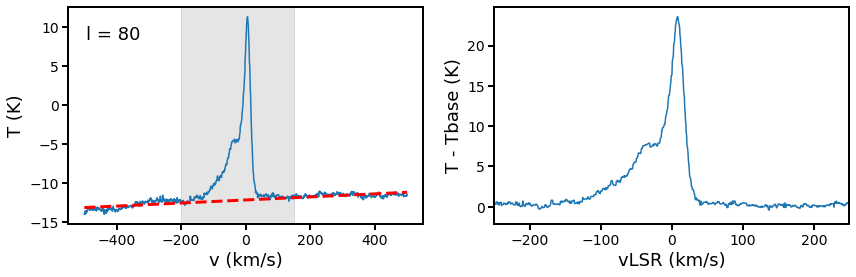

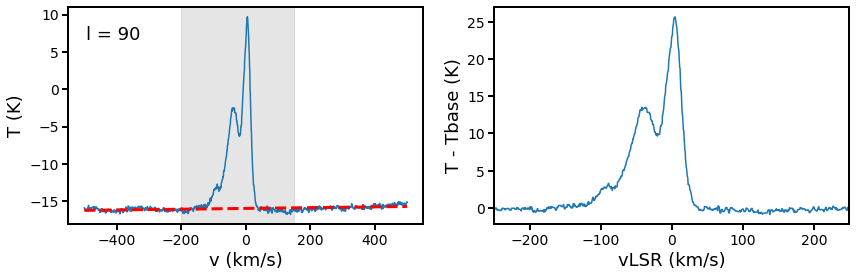

In [8]:
# flag to decide whether to write the reduced files out or not
write = True

if write:
    reduced_subdir = 'reduced_spectra'
    reduced_dir = cwd + '/' + reduced_subdir
    # check to see if a "reduced" subdirectory exists, else make one
    if not os.path.isdir(reduced_dir):
        print('Creating subdirectory', reduced_subdir, ' in ', cwd)
        os.mkdir(reduced_dir)

vbpass_lo = -500
vbpass_hi = 500

vbase_lo = -200
vbase_hi = 150

fig = plt.figure(figsize=(12,8))
for i in range(len(obs['file'])):
    f = 'calibrated_spectra/'+obs['file'][i]+'_cal.csv'
    v, T = np.genfromtxt(f, delimiter=',', unpack=True)
    bpass = (v > vbpass_lo) & (v < vbpass_hi)
    v = v[bpass]
    T = T[bpass]
    
    ibase = (v < vbase_lo) + (v > vbase_hi)
    order = 1
    p = np.polyfit(v[ibase], T[ibase], order)
    Tbase = np.polyval(p, v)
    
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(v, T)
    ax1.plot(v, Tbase, 'r--', lw=3)
    ax1.set_xlabel('v (km/s)')
    ax1.set_ylabel('T (K)')
    ax1.text(0.05, 0.85, str('l = {0}'.format(obs['longitude'][i])), fontsize=18, ha='left', transform=ax1.transAxes)
    ax1.axvspan(vbase_lo, vbase_hi, color='black', alpha=0.1)
    
    # barycentric correction
    b = 0
    l = obs['longitude'][i]
    vcorr1 = vbary(l, b, obs['tobs'][i])
    lrad = l * np.pi/180
    brad = b * np.pi/180
    vcorr2 = 9*np.cos(lrad)*np.cos(brad) + 12*np.sin(lrad)*np.cos(brad) + 7*np.sin(brad)
    vLSR = v + vcorr1 + vcorr2
    print('{0} Barycentric correction = {1:6.2f} km/s, LSR correction = {2:6.2f} km/s'.format(f, vcorr1, vcorr2))
    
    ax2 = fig.add_subplot(122)
    ax2.plot(vLSR, T-Tbase)
    ax2.set_xlabel('vLSR (km/s)')
    ax2.set_ylabel('T - Tbase (K)')
    ax2.set_xlim(-250,250)

    if write:
        fr = obs['file'][i]+'_reduced.csv'
        print('Writing reduced spectrum to ', fr)
        with open(reduced_dir + '/' + fr, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(zip(vLSR, T-Tbase))